# ResNet

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from functools import partial
import pickle as pk

from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import RandomBrightness, RandomContrast, RandomCrop, RandomFlip, RandomRotation
from keras.callbacks import EarlyStopping

from cascid.configs.config import DATA_DIR

IMAGE_SIZE = (256,256,3)
RANDOM_STATE = 42
METRICS = ['loss', 'acc', 'auc']

EXPERIMENT_DIR = DATA_DIR / 'experiments'
MODEL_PATH = DATA_DIR / 'dip' / 'model_resnet34_isic_noreg_noaug_raw'
MODEL_PATH.mkdir(exist_ok=True, parents=True)

2022-10-17 11:15:53.829958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 11:15:54.033478: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 11:15:54.670637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dell/anaconda3/envs/dell/lib/python3.10/site-packages/cv2/../../lib64:
2022-10-17 11:15:54.670722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_

## Dataset

In [18]:
from cascid.datasets.isic import database

x_train, x_test, y_train, y_test = database.get_train_test_images_raw()
categories = set(y_train.flatten().tolist())

OHE = OneHotEncoder(sparse=False)
y_train=np.array(list(map(lambda x: "Cancer" if x in ['basal cell carcinoma', 'melanoma', 'squamous cell carcinoma'] else "Not", y_train))).reshape(-1,1)
y_test=np.array(list(map(lambda x: "Cancer" if x in ['basal cell carcinoma', 'melanoma', 'squamous cell carcinoma'] else "Not", y_test))).reshape(-1,1)
y_train = OHE.fit_transform(y_train)
y_test = OHE.transform(y_test)

print("x_train shape: {0}".format(x_train.shape))
print("x_test shape: {0}".format(x_test.shape))
print("y_train shape: {0}".format(y_train.shape))
print("y_test shape: {0}".format(y_test.shape))

x_train shape: (7265, 256, 256, 3)
x_test shape: (1817, 256, 256, 3)
y_train shape: (7265, 2)
y_test shape: (1817, 2)


In [19]:
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

## Model

In [20]:
def ResNet(amt_64, amt_128, amt_256, amt_512, augmentation = False):
    # Aurelien Geron, Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow.
    DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding="SAME", use_bias=False )# , kernel_regularizer=keras.regularizers.l1(l1=0.001)) 

    class ResidualUnit(keras.layers.Layer):
        def __init__(self, filters, strides=1, activation="relu", **kwargs):
            super().__init__(**kwargs)
            self.activation = keras.activations.get(activation)
            self.main_layers = [
                DefaultConv2D(filters, strides=strides), 
                keras.layers.BatchNormalization(),
                self.activation,
                DefaultConv2D(filters),
                keras.layers.BatchNormalization(),
                keras.layers.SpatialDropout2D(0.2)
            ]
            self.skip_layers = []
            if strides > 1:
                self.skip_layers = [
                    DefaultConv2D(filters, kernel_size=1, strides=strides),
                    keras.layers.BatchNormalization()
                ]
        def call(self, inputs):
            Z = inputs
            for layer in self.main_layers:
                Z = layer(Z)
            skip_Z = inputs
            for layer in self.skip_layers:
                skip_Z = layer(skip_Z)
            return self.activation(Z + skip_Z)

    model = keras.models.Sequential()
    model.add(Input(shape=IMAGE_SIZE))
    if augmentation:
        # model.add(RandomBrightness(factor=(-0.2, 0.2), value_range=(0.0, 1.0), seed=RANDOM_STATE) # Randomly change brightness anywhere from -30% to +30%
        # model.add(RandomContrast(factor=0.5, seed=RANDOM_STATE)) # Randomly change contrast anywhere from -30% to +30%
        model.add(RandomFlip(mode="horizontal_and_vertical", seed=RANDOM_STATE)), # Randomly flip images either horizontally, vertically or both
        model.add(RandomRotation(factor=(-0.15, 0.15), fill_mode="nearest", interpolation="bilinear", seed=RANDOM_STATE)) # Randomly rotate anywhere from -30% * 2PI to +30% * 2PI, filling gaps by using 'nearest' strategy)
    model.add(DefaultConv2D(64, kernel_size=7, strides=2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
    prev_filters = 64
    for filters in [64] * amt_64 + [128] * amt_128 + [256] * amt_256 + [512] * amt_512:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(2, activation="softmax"))
    return model

def dump_results(model, history, path):
    model.save(path)

    with open(path / "history.pkl", "wb") as fl:
        pk.dump(history, fl)

def load_results(path):
    model= load_model(path)

    with open(path / "history.pkl", "rb") as fl:
        history = pk.load(fl)
    
    return model, history

In [21]:
# 'resnet18': (2, 2, 2, 2)
# 'resnet34': (3, 4, 6, 3)

model = ResNet(3,4,6,3, augmentation=False)

2022-10-17 11:31:40.282631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 11:31:40.289556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 11:31:40.290188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 11:31:40.291153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [22]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['acc', keras.metrics.AUC()] # loss is implied
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 64, 64, 64)       74240     
 )                                                               
                                                        

In [23]:
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.15
)

Epoch 1/100


2022-10-17 11:31:55.954358: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-10-17 11:31:56.497192: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


49/49 [==============================] - 21s 303ms/step - loss: 0.8024 - acc: 0.6126 - auc: 0.6477 - val_loss: 61995.9844 - val_acc: 0.5128 - val_auc: 0.5128
Epoch 2/100
49/49 [==============================] - 13s 270ms/step - loss: 0.6484 - acc: 0.6567 - auc: 0.6988 - val_loss: 1.0103 - val_acc: 0.5266 - val_auc: 0.5589
Epoch 3/100
49/49 [==============================] - 13s 270ms/step - loss: 0.6363 - acc: 0.6659 - auc: 0.7152 - val_loss: 3.7889 - val_acc: 0.5459 - val_auc: 0.5574
Epoch 4/100
49/49 [==============================] - 13s 270ms/step - loss: 0.6291 - acc: 0.6771 - auc: 0.7234 - val_loss: 0.8609 - val_acc: 0.5385 - val_auc: 0.5657
Epoch 5/100
49/49 [==============================] - 13s 270ms/step - loss: 0.6280 - acc: 0.6713 - auc: 0.7280 - val_loss: 4.3357 - val_acc: 0.5853 - val_auc: 0.6009
Epoch 6/100
49/49 [==============================] - 13s 270ms/step - loss: 0.6135 - acc: 0.6753 - auc: 0.7371 - val_loss: 0.5970 - val_acc: 0.6771 - val_auc: 0.7485
Epoch 7/100


## Results

In [24]:
dump_results(model, history.history, MODEL_PATH)
model, history = load_results(MODEL_PATH)

INFO:tensorflow:Assets written to: /home/dell/.cascid_data/dip/model_resnet34_isic_noreg_noaug_raw/assets


INFO:tensorflow:Assets written to: /home/dell/.cascid_data/dip/model_resnet34_isic_noreg_noaug_raw/assets


In [ ]:
# Merge history from multiple steps
# with open(MODEL_PATH / 'history.pkl', 'rb') as fl:
#     h = pk.load(fl)

# for k in h.keys():
#     history[k] = h[k] + history[k]

In [31]:
from collections import Counter
cnt = Counter(list(OHE.inverse_transform(y_train).flatten()))
pct_cancer = cnt['Cancer']/(cnt['Cancer'] + cnt['Not'])
pct_cancer
if pct_cancer > 0.5:
    pct_cancer = 1-pct_cancer

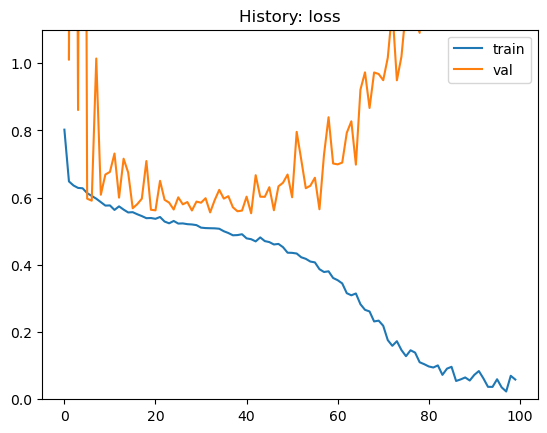

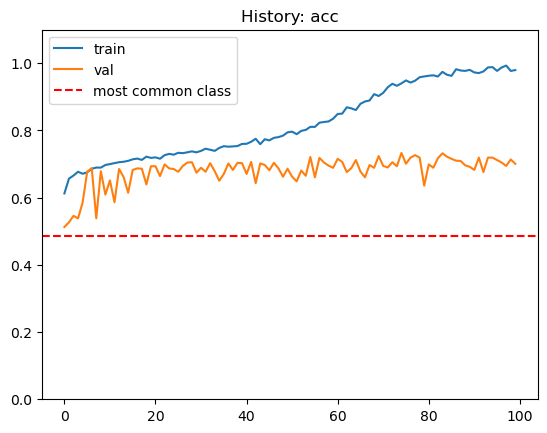

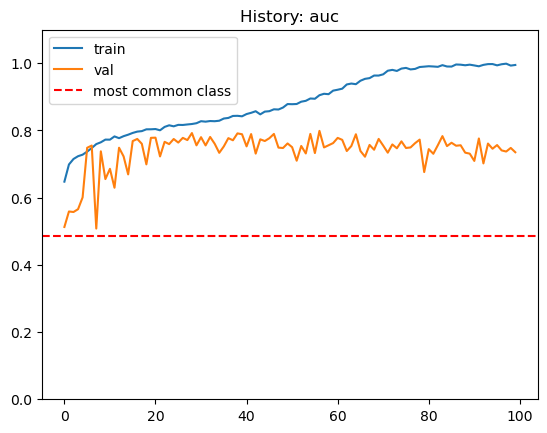

In [33]:
for m in METRICS:
    train_m = history[m]
    val_m = history['val_'+m]
    x = range(len(train_m))
    plt.title("History: " + m)
    plt.plot(x, train_m, label='train')
    plt.plot(x, val_m, label='val')
    if m != 'loss':
        plt.axhline(pct_cancer, label='most common class', c='red', ls='--')
    plt.ylim((0, 1.1))
    plt.legend()
    plt.show();

In [40]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Greens, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig('Assets/files/' + title + '.pdf')
    return ax

y_pred_train = OHE.inverse_transform(model.predict(x_train))
y_pred_test = OHE.inverse_transform(model.predict(x_test))

57/57 [==============================] - 1s 19ms/step


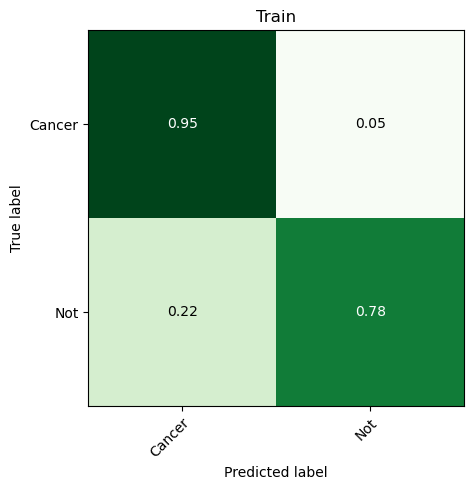

In [41]:
plot_confusion_matrix(
    y_true=OHE.inverse_transform(y_train).flatten(),
    y_pred=y_pred_train.flatten(),
    classes=['Cancer', 'Not'],
    normalize=True,
    title='Train'
);

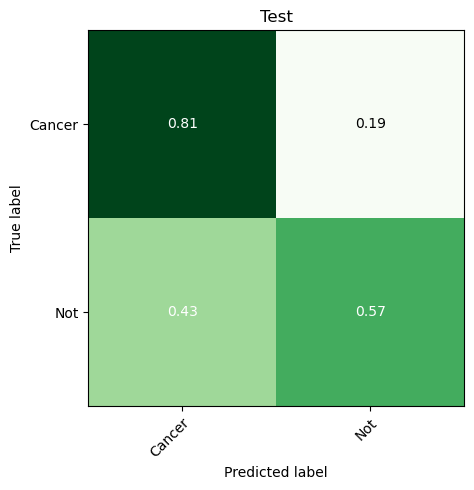

In [42]:
plot_confusion_matrix(
    y_true=OHE.inverse_transform(y_test).flatten(),
    y_pred=y_pred_test.flatten(),
    classes=['Cancer', 'Not'],
    normalize=True,
    title='Test'
);